## Retrieving study-site geolocation information from scientific papers

The following notebook describes an automated workflow for analysing the spatial distribution of study sites based on a given set of full-length articles in pdf format. The original script was created by Acheson, E. & Purves, R.S. and can be cloned from their [github repository](https://github.com/eacheson/pyscine). Only in the rear part of the processing chain slight modifications were made to the original script. In brief, the workflow consisted of the following substeps:
1. [conversion of pdfs to xml and txt files](#part1)  
2. [extraction of revelant sections & sentences](#part2)
3. [filtering for location names](#part3)
4. [geocoding locations using the Google API](#part4)  
5. [mapping results](#part5) 
 
For further details, the reader is referred to the corresponding publication: [Acheson E, Purves RS (2021)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0244918) Extracting and modeling geographic information from scientific articles. Only in the 

### setup & prerequisites

In [1]:
# general imports
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pandas as pd
import re
import sys
import subprocess
import time
import tqdm.notebook
import urllib.request
import xml.etree.ElementTree as ET
import zipfile

# jupyter cell configuration
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# pysci specific imports
# pysci package developed by Acheson & Purves (see above)
# needs to be downloaded from github and copied into site-package dir manually   
from pysci import convertpdf as pdf
from pysci import docutils as du
from pysci import geoparse as gp
from pysci import geocode as gc

# natural language processing libraries (incl. named entity recognition)
import nltk
import nltk.data
from nltk.tag import StanfordNERTagger

c:\Users\felix\.virtualenvs\bibliometry\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [8]:
# java library cermine for processing pdfs -> xml
cermine_url = r'https://maven.ceon.pl/artifactory/kdd-releases/pl/edu/icm/cermine/cermine-impl/1.13/cermine-impl-1.13-jar-with-dependencies.jar'
cermine_jar_local_path = os.path.join("software", 'cermine-impl-1.13-jar-with-dependencies.jar')

# download the cermine jar to software dir
filename, headers = urllib.request.urlretrieve(cermine_url, cermine_jar_local_path)

In [43]:
# stanford named entity recognition library
ner_url = r'https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip'
ner_local_path = os.path.join("software", os.path.split(ner_url)[-1])

# download stanford ner to software dir
filename, headers = urllib.request.urlretrieve(ner_url, ner_local_path)

# extract application file
with zipfile.ZipFile(ner_jar_local_path, 'r') as zip_ref:
    zip_ref.extractall("software")
    ner_local_path_ex = os.path.join("software", os.path.split(zip_ref.namelist()[0])[0])

# remove zip file
os.remove(ner_local_path) 

In [56]:
# locate java executable
java_path = "C:/Program Files/Java/jdk1.8.0_311/bin/java.exe"
os.environ['JAVAHOME'] = java_path

In [54]:
# directory containing the PDFs to process
articles_dir = 'c:\\Users\\felix\\github\\bibliometric_analyses_sar_crops\\refs_full_article'

# nltk customization
# nltk.download('perluniprops')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
StanfordBaseDir = os.path.join(os.getcwd(), ner_local_path_ex)
os.environ['CLASSPATH'] = StanfordBaseDir
os.environ['STANFORD_MODELS'] = os.path.join(StanfordBaseDir, 'classifiers')
tagger = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

C:\Users\felix\.virtualenvs\bibliometry\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


<a id="part1"></a>  
### step 1: conversion of pdfs to xml and txt files

In [9]:
# conversion of pdfs to xml docs 
# directory containing the PDFs to process
articles_dir = 'c:\\Users\\felix\\github\\bibliometric_analyses_sar_crops\\refs_full_article'

# function for conversion
def convert_pdf_dir_to_xml(pdf_dir, verbose=True):
    output = subprocess.run([r"java", '-cp', cermine_jar_local_path, 'pl.edu.icm.cermine.ContentExtractor', 
                             '-path', articles_dir], stdout=subprocess.PIPE).stdout
    result_string = output.decode('utf-8', 'ignore')
    result_output = result_string.splitlines()
    for line in result_output:
        if verbose:
            print(line)
    return result_output

# convert all pdfs
print("Processing pdfs in %s using Cermine..." %articles_dir)
time1 = time.time()
output = convert_pdf_dir_to_xml(articles_dir, verbose=False)
time2 = time.time()
print("Conversion of all files in %s took %0.1fmin" %(articles_dir, (time2-time1)/60.0))

Processing pdfs in c:\Users\felix\github\bibliometric_analyses_sar_crops\refs_full_article using Cermine...
Conversion of all files in c:\Users\felix\github\bibliometric_analyses_sar_crops\refs_full_article took 31.3min


In [28]:
# conversion of pdfs to txt
files_in = 0
files_converted = 0

print("Processing pdfs in %s using pdfminer..." %articles_dir)

time1 = time.time()

for root, dirs, files in os.walk(articles_dir):
    # ignore files that aren't pdf
    files[:] = [f for f in files if os.path.splitext(f)[1].lower() == du.PDF_extension]
    for filename_pdf in files:
        files_in += 1
        filepath_pdf = os.path.join(root,filename_pdf)
        filename_raw = du.remove_extension(filename_pdf)
        filename_txt = filename_raw + du.TXT_extension
        filepath_txt = os.path.join(root,filename_txt)
        if os.path.isfile(filepath_txt):
            #print("Skipping %s" %filepath_txt[:90])
            continue
        success = pdf.convert_pdf_to_text(filepath_pdf, filepath_txt, verbose=False)
        if success:
            files_converted += 1
        else:
            try:
                os.remove(filepath_txt)
            except PermissionError as e:
                print("PermissionError while trying to delete file %s" %filepath_txt[:90])
            
print("We read in %s pdf files and output %s text files." %(files_in, files_converted))

time2 = time.time()
print('Conversion of all files in %s took %0.1fmin' %(articles_dir, (time2-time1)/60.0))

Processing pdfs in c:\Users\felix\github\bibliometric_analyses_sar_crops\refs_full_article using pdfminer...
PDFTextExtractionNotAllowed on file SONOBE, TANI et al. - APPLICATION OF MULTITEMPORAL TERRASARX DATA.pdf
We read in 201 pdf files and output 0 text files.
Conversion of all files in c:\Users\felix\github\bibliometric_analyses_sar_crops\refs_full_article took 0.0min


<a id="part2"></a>  
### step 2: extraction of revelant sections & sentences

In [7]:
documents = []  # list of ScienceDocs
min_characters = 100

count_pdf_files = 0
count_txt_files = 0
count_xml_files = 0

for root, dirs, files in os.walk(articles_dir):
    # ignore files that aren't pdf
    files[:] = [f for f in files if os.path.splitext(f)[1] == du.PDF_extension]
    for filename_pdf in files:
        count_pdf_files += 1
        filepath_pdf = os.path.join(root,filename_pdf)
        filename_raw = du.remove_extension(filename_pdf)
        
        # create ScienceDoc object
        scidoc = du.ScienceDoc(corpus_name='sar-crops-corpus', file_name=filename_raw)
        documents.append(scidoc)
        
        ### PROCESS TXT ###
        filename_txt = filename_raw + du.TXT_extension
        filepath_txt = os.path.join(root,filename_txt)
        if os.path.isfile(filepath_txt):
            count_txt_files += 1
            scidoc.has_text = True
            with open(filepath_txt, 'r', encoding='utf-8') as f:
                scidoc.raw_contents = f.read()
                
            ### Detect methods sections and extract relevant text from TXT
            # here using regular expression for Orchards corpus, TXT
            section_titles_txt, relevant_text_txt = gp.extract_methods_text(scidoc.raw_contents, 
                                                                            re_to_match=gp.RE_ORCHARDS_METHODS_TEXT)
        else:
            section_titles_txt = []
            relevant_text_txt = ''
            
        ### PROCESS XML ###
        filename_xml = filename_raw + du.XML_extension
        filepath_xml = os.path.join(root,filename_xml)
        if os.path.isfile(filepath_xml):
            count_xml_files += 1
            # defaults to False in class
            scidoc.has_xml = True
            tree = ET.parse(filepath_xml)
            xml_root = tree.getroot()
            scidoc.xml_root = xml_root
            # Extract info directly from XML
            scidoc.title = du.get_article_title(xml_root)
            scidoc.year = du.get_publication_year(xml_root)
            scidoc.journal = du.get_journal_title(xml_root)
            scidoc.xml_contents = du.extract_content_text(xml_root)
            scidoc.authors, scidoc.affiliations = du.get_article_authors_affiliations(xml_root)
            scidoc.countries = du.get_affiliation_countries(xml_root)
            
            ### Detect methods sections and extract relevant text from XML
            # here using regular expression for Orchards corpus, XML
            methods_content_xml = gp.extract_methods_xml(scidoc.xml_root, re_to_match=gp.RE_ORCHARDS_METHODS_HEADINGS)
            section_titles_xml = [item[0] for item in methods_content_xml]  # a list
            relevant_text_list_xml = [item[1] for item in methods_content_xml]  # a list
            relevant_text_xml = '\n\n'.join(txt for txt in relevant_text_list_xml)
        else:
            section_titles_xml = []
            relevant_text_xml = ''
            
        ### Continue with XML or TXT? ###
        # use XML content unless:
        #   - we found no relevant headings in XML, or
        #   - we have insufficient content in the XML text portions
        use_xml = True
        if (len(section_titles_xml) == 0) or (len(relevant_text_xml) < min_characters):
            use_xml = False

        scidoc.use_xml = use_xml
        section_titles = []
        relevant_text = ''
        if use_xml:
            scidoc.methods_sections = section_titles_xml
            scidoc.relevant_text = relevant_text_xml
        else:
            scidoc.methods_sections = section_titles_txt
            scidoc.relevant_text = relevant_text_txt
            
print("We have %s ScienceDocs." %len(documents))
print("We have %s pdf documents." %count_pdf_files)
print("We have %s txt documents." %count_txt_files)
print("We have %s xml documents." %count_xml_files)

We have 201 ScienceDocs.
We have 201 pdf documents.
We have 200 txt documents.
We have 201 xml documents.


<a id="part3"></a> 
### step 3: filtering for location names

In [67]:
# start from the ScienceDoc instances
science_docs = documents

# extract location names
for scidoc in tqdm.tqdm(science_docs, "filter location names"):
    ### PARSE TITLE FROM XML ###
    if scidoc.has_xml:
        if scidoc.title:
            scidoc.title_locations = []
            title_string = scidoc.title
            # process title
            title_clean = gp.multireplace(title_string)
            sent_tok = nltk.word_tokenize(title_clean)
            sent_pos = nltk.pos_tag(sent_tok)
            sent_ner = tagger.tag(sent_tok)
            # customizable extract method
            extracted_chunks = gp.extract_chunks_from_sentence(
                sent_ner, include_cardinal=True, include_other_spatial=True, include_types=True)
            if extracted_chunks:
                # print("### Found %s location candidates in title:" %len(extracted_chunks))
                for loc_chunk in extracted_chunks:
                    loc_chunk_str = gp.tuple_list_to_string(loc_chunk)
                    # print("\t%s" %loc_chunk_str)
                extracted_chunks_pos = gp.filter_chunk_candidates(sent_tok, extracted_chunks)
                # print("### Kept %s location chunks in title:" %len(extracted_chunks_pos))
                for loc_chunk_keep in extracted_chunks_pos:
                    loc_chunk_keep_str = gp.tuple_list_to_string(loc_chunk_keep)
                    # keep just the final filtered locations - empty list means we had none
                    scidoc.title_locations.append(loc_chunk_keep_str)
                    # print("\t%s" %loc_chunk_keep_str)
        else:
            #print("No title for this article.")
            scidoc.title_locations = gp.NO_TITLE_STRING  
    else:
        #print("No xml file for this article.")
        scidoc.title_locations = gp.NO_XML_STRING

    ### Process article contents
    content_locations = []
    content_locations_filtered = []
    location_sentences = []
    for par in re.split('[\n]{2,}', scidoc.relevant_text):
        par_clean = gp.multireplace(par)
        #print("Clean paragraph: %s" % (par_clean))
        sentences = nltk.sent_tokenize(par_clean)
        for sent in sentences:
            sent_added = False
            sent_tok = nltk.word_tokenize(sent)
            sent_pos = nltk.pos_tag(sent_tok)
            sent_ner = tagger.tag(sent_tok)
            # customizable extract method
            extracted_chunks = gp.extract_chunks_from_sentence(
                sent_ner, include_cardinal=True, include_other_spatial=True, include_types=True)
            if extracted_chunks:
                #print("NER tagged sentence:\n %s" %sent_ner)
                # print("### Found %s location candidates in sentence:" %len(extracted_chunks))
                for loc_chunk in extracted_chunks:
                    loc_chunk_str = gp.tuple_list_to_string(loc_chunk)
                    content_locations.append(loc_chunk_str)
                    # print("\t%s" %loc_chunk_str)
                extracted_chunks_pos = gp.filter_chunk_candidates(sent_tok, extracted_chunks)
                # print("### Kept %s location chunks:" %len(extracted_chunks_pos))
                for loc_chunk_keep in extracted_chunks_pos:
                    loc_chunk_keep_str = gp.tuple_list_to_string(loc_chunk_keep)
                    content_locations_filtered.append(loc_chunk_keep_str)
                    # print("\t%s" %loc_chunk_keep_str)
                    if not sent_added:
                        sent_no_breaks = sent.replace('\n', ' ')
                        location_sentences.append(sent_no_breaks)
                        sent_added = True
            
    scidoc.content_locations = content_locations
    scidoc.content_locations_filtered = content_locations_filtered
    scidoc.location_sentences = location_sentences

filter location names: 100%|██████████| 201/201 [48:33<00:00, 14.50s/it] 


### Done.


In [68]:
# flatten each list entry to a string instead of a list
filenames_for_df = []
use_xml_for_df = []
methods_for_df = []
titles_for_df = []
title_locations_for_df = []
content_locations_for_df = []
content_locations_filtered_for_df = []
location_sentences_for_df = []
for doc in science_docs:
    filenames_for_df.append(doc.file_name)
    use_xml_for_df.append(doc.use_xml)
    try:
        titles_for_df.append(doc.title)
    except AttributeError:
        titles_for_df.append(gp.NO_TITLE_STRING)
    if doc.title_locations == gp.NO_XML_STRING or doc.title_locations == gp.NO_TITLE_STRING:
        title_locations_for_df.append(doc.title_locations)
    else:
        title_locations_for_df.append('; '.join([x for x in doc.title_locations]))
    try:
        methods_for_df.append(doc.methods_sections)
    except AttributeError:
        methods_for_df.append('')
    if not doc.content_locations:
        content_locations_for_df.append('')
    elif doc.content_locations == gp.NO_METHODS_STRING:
        content_locations_for_df.append(doc.content_locations)
    else:
        content_locations_for_df.append('; '.join([x for x in doc.content_locations]))
    if not doc.content_locations_filtered:
        content_locations_filtered_for_df.append('')
    elif doc.content_locations_filtered == gp.NO_METHODS_STRING:
        content_locations_filtered_for_df.append(doc.content_locations_filtered)
    else:
        content_locations_filtered_for_df.append('; '.join([x for x in doc.content_locations_filtered]))
    if not doc.location_sentences:
        location_sentences_for_df.append('')
    else:
        location_sentences_for_df.append(doc.location_sentences)

df_geoparsed = pd.DataFrame({'filename_only':filenames_for_df, 
                            'use_xml':use_xml_for_df,
                            'title':titles_for_df,
                            'title_locations':title_locations_for_df,
                            'methods_sections':methods_for_df,
                            'content_locations':content_locations_for_df,
                            'content_locations_filtered':content_locations_filtered_for_df,
                            'location_sentences':location_sentences_for_df})

# increase the column width display of pandas tables to view full cells
#pd.options.display.max_colwidth = 500

df_geoparsed

,filename_only,use_xml,title,title_locations,methods_sections,content_locations,content_locations_filtered,location_sentences
0,"ABDIKAN, SEKERTEKIN et al. - BACKSCATTER ANALY...",True,BACKSCATTER ANALYSIS USING MULTI-TEMPORAL SENT...,"KONYA BASIN, TURKEY","[2. MATERIALS AND METHODOLOGY, 2.1 Study Area:...","Konya; central Anatolia Turkey,","Konya; central Anatolia Turkey,",[ The test area is located at Konya bas...
1,"ABUBAKAR, WANG et al. - MAPPING MAIZE FIELDS B...",True,Mapping Maize Fields by Using Multi-Temporal S...,"Makarfi, Northern Nigeria, Africa","[2. Materials and Methods, 2.1. Study Area]",Makarfi Local Government Area (central; Kaduna...,"Kaduna State, Nigeria (; Kaduna State; Norther...",[ Makarfi Local Government Area (cent...
2,"AINSWORTH, WILLIAMS - A SIMULATION STUDY OF TO...",False,A SIMULATION STUDY OF TOPOGRAPHIC EFFECTS ON P...,,[],,,
3,"ALVISI, VOLTA et al. - PREDICTORS OF WEANING O...",False,Predictors of weaning outcome in chronic obstr...,,[Materials and methods],S. Anna Hospital); American Thoracic Society; ...,S. Anna Hospital),[The initial weaning trial included 81 COPD pa...
4,"AMELARD, WONG et al. - UNSUPERVISED CLASSIFICA...",True,UNSUPERVISED CLASSIFICATION OF AGRICULTURAL LA...,,[2. METHODOLOGY],Pauli,,
...,...,...,...,...,...,...,...,...
196,"ZHANG, WU - CROP CLASSIFICATION BY FORWARD NEURAL",False,Crop Classification by Forward Neural Network ...,,[],,,
197,"ZHANG, WU et al. - MAPPING UPTODATE PADDY RICE...",True,Mapping up-to-Date Paddy Rice Extent at 10 M R...,China,"[2. Materials, 2.1. Study Area, 3. Methodology]","China; Northeast, Yangtze River Basin; Pearl r...","China; Northeast, Yangtze River Basin; Pearl r...",[ China has approximately 120 million...
198,"ZHAO, CHEN et al. - EVALUATION OF THREE DEEP L...",False,Evaluation of Three Deep Learning Models for E...,"Zhanjiang, China",[3. Methodology],,,
199,"ZHOU, LUO et al. - DCNBASED SPATIAL FEATURES F...",True,DCN-Based Spatial Features for Improving Parce...,,"[2. Methods, 2.1. Study Area and Dataset]","Hunan Province, China,","Hunan Province, China,","[2019, 11, x FOR PEER REVIEW 4 of 22 The study..."


In [69]:
# now each list item (each final content location) will be a separate row in the df
filenames_flat = []
content_locations_filtered_flat = []
location_sentences_flat = []
use_xml_flat = []
for doc in science_docs:
    if not doc.content_locations_filtered:
        # store the 'no location' case!
        content_locations_filtered_flat.append(gp.NO_LOCATIONS_STRING)
        location_sentences_flat.append(gp.NO_LOCATIONS_STRING)
        use_xml_flat.append(doc.use_xml)
        filenames_flat.append(doc.file_name)
        continue
    elif doc.content_locations_filtered == gp.NO_METHODS_STRING:
        content_locations_filtered_flat.append(gp.NO_METHODS_STRING)
        location_sentences_flat.append(gp.NO_METHODS_STRING)
        use_xml_flat.append(doc.use_xml)  # we store 'N/A' already
        filenames_flat.append(doc.file_name)
    else:
        for location in doc.content_locations_filtered:
            content_locations_filtered_flat.append(location)
            use_xml_flat.append(doc.use_xml)
            filenames_flat.append(doc.file_name)
            found_sentence = False
            for sentence in doc.location_sentences:
                if location in sentence:
                    found_sentence = True
                    location_sentences_flat.append(sentence)
                    break
            if not found_sentence:
                location_sentences_flat.append('no exact sentence match')

df_flat = pd.DataFrame({'filename':filenames_flat,
                        'content_locations':content_locations_filtered_flat,
                        'use_xml':use_xml_flat,
                        'location_sentences':location_sentences_flat})

df_flat.head()

,filename,content_locations,use_xml,location_sentences
0,"ABDIKAN, SEKERTEKIN et al. - BACKSCATTER ANALY...",Konya,True,The test area is located at Konya basi...
1,"ABDIKAN, SEKERTEKIN et al. - BACKSCATTER ANALY...","central Anatolia Turkey,",True,The test area is located at Konya basi...
2,"ABUBAKAR, WANG et al. - MAPPING MAIZE FIELDS B...","Kaduna State, Nigeria (",True,Makarfi Local Government Area (centr...
3,"ABUBAKAR, WANG et al. - MAPPING MAIZE FIELDS B...",Kaduna State,True,Makarfi Local Government Area (centr...
4,"ABUBAKAR, WANG et al. - MAPPING MAIZE FIELDS B...",Northern Guinea,True,The study area within the Northern Guinea sava...


In [184]:
# save results
df_geoparsed.to_csv(os.path.join('results', 'articles_geoparsed.csv'), sep='\t', index=False, quotechar='"', encoding='utf-8')
df_flat.to_csv(os.path.join('results', 'locations.csv'), sep='\t', index=False, quotechar='"', encoding='utf-8')

# rename df
df_locations = df_flat

<a id="part4"></a> 
### step 4: geocoding locations using the Google API 

In [109]:
# create googlemaps.client object
# use key stored in a config file
from config import *
gmaps = gc.create_google_geocoder(api_key=api_key)

# cache so we don't re-query identical strings
local_cache_google = {}

# or load existing cache
#local_cache_google = du.load_data('local_cache_google.pkl')
#print("The cache has values for %s string keys." %len(local_cache_google))

In [95]:
# retrieve lat/long data using google api
loc_clean = []
loc_lats = []
loc_lons = []
loc_strings = []
loc_types = []

for content_location in df_locations['content_locations'].tolist():
    if content_location == gp.NO_METHODS_STRING or content_location == gp.NO_LOCATIONS_STRING:
        # don't geocode these but store placeholder strings
        loc_clean.append(content_location)
        loc_lats.append(content_location)
        loc_lons.append(content_location)
        loc_strings.append(content_location)
        loc_types.append(content_location)
        continue
    clean_text = gc.clean_for_geocode(content_location)
    loc_clean.append(clean_text)
    #print("\tgeocoding text: %s" %clean_text)
    top = gc.geocode_with_cache_google(clean_text, gmaps, local_cache_google)
    if top:
        # get point
        geometry = top['geometry']
        pt = geometry['location']
        # store stuff
        loc_lats.append(pt['lat'])
        loc_lons.append(pt['lng'])
        loc_strings.append(top['formatted_address'])
        loc_types.append(geometry['location_type'])
    else:
        #print("\tWe had no top result")
        loc_lats.append(gc.NO_RESULT_STRING)
        loc_lons.append(gc.NO_RESULT_STRING)
        loc_strings.append(gc.NO_RESULT_STRING)
        loc_types.append(gc.NO_RESULT_STRING)

print("Done.")

Done.


In [186]:
# repickle the cache at the end...
print("The cache now has values for %s string keys." %len(local_cache_google))
du.pickle_data(local_cache_google, 'local_cache_google.pkl')

The cache now has values for 0 string keys.
pickled data at local_cache_google.pkl


True

In [187]:
# format results
# create df
df_locations['clean_content_loc'] = loc_clean
df_locations['geocode_lat'] = loc_lats
df_locations['geocode_lon'] = loc_lons
df_locations['geocode_str'] = loc_strings
df_locations['geocode_type'] = loc_types

# reorder cols
cols_in_order = ['filename', 'content_locations', 'clean_content_loc', 'geocode_str', 'geocode_type', 
                 'geocode_lat', 'geocode_lon', 'use_xml', 'location_sentences']
df_locations = df_locations.loc[:,cols_in_order]

# export to file
df_locations.to_csv(os.path.join('results', 'locations_geocoded.csv'), sep='\t', index=False, quotechar='"', encoding='utf-8')

# view df
df_locations.head()

ValueError: Length of values (688) does not match length of index (522)

In [200]:
# cleaning results
# removing multiple occurences of same location for one study
df_locations.drop_duplicates(["filename", "geocode_lat", "geocode_lon"], inplace=True)

# remove all entries without geocoding result
df_locations = df_locations[pd.to_numeric(df_locations.geocode_lat, errors='coerce').notnull()]

# remove locations geocoded as buildings
df_locations = df_locations[df_locations["geocode_type"] != "ROOFTOP"]

# export to file
df_locations.to_csv(os.path.join('results', 'locations_geocoded.csv'), sep='\t', index=False, quotechar='"', encoding='utf-8')

# view
df_locations.head(10)

In [231]:
print(f"For a total of {len(pd.unique(df_locations['filename']))} studies geocoded information could be obtained.")

For a total of 128 studies geocoded information could be obtained.


<a id="part5"></a> 
### step 5: mapping results

In [2]:
df_locations = pd.read_csv(os.path.join('results', 'locations_geocoded.csv'), sep='\t', quotechar='"', encoding='utf-8')

In [3]:
df_geocoded = df_locations[["filename", "geocode_str", "geocode_lat", "geocode_lon", "location_sentences"]].copy()
df_geocoded['geocode_lat'] = df_geocoded['geocode_lat'].astype(float)
df_geocoded['geocode_lon'] = df_geocoded['geocode_lon'].astype(float)
df_geocoded.head()

,filename,geocode_str,geocode_lat,geocode_lon,location_sentences
0,"ABDIKAN, SEKERTEKIN et al. - BACKSCATTER ANALY...","Konya, Turkey",37.874643,32.493155,The test area is located at Konya basi...
1,"ABDIKAN, SEKERTEKIN et al. - BACKSCATTER ANALY...",Turkey,38.963745,35.243322,The test area is located at Konya basi...
2,"ABUBAKAR, WANG et al. - MAPPING MAIZE FIELDS B...","Kaduna, Nigeria",10.376401,7.709454,Makarfi Local Government Area (centr...
3,"ABUBAKAR, WANG et al. - MAPPING MAIZE FIELDS B...","120106, Northern Guinea, Nigeria",6.995887,3.990235,The study area within the Northern Guinea sava...
4,"ARIAS, CAMPO-BESCOS et al. - CROP CLASSIFICATI...","Navarre, Spain",42.695391,-1.676069,The study area covers the agricultur...


In [4]:
# definition of continent polygons
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = countries[["continent", "name", "geometry"]]

# convert geocoded results into geopandas df
gpdf_geocoded = gpd.GeoDataFrame(df_geocoded, geometry=gpd.points_from_xy(df_geocoded.geocode_lon, df_geocoded.geocode_lat))
gpdf_geocoded = gpdf_geocoded.set_crs(epsg=4326)

# spatial join of points to countries
pubs_country = gpd.sjoin(countries, gpdf_geocoded)

# aggregate number of pubs per country 
pubs_per_country = pubs_country.groupby("name").agg(
  pubs_per_country=pd.NamedAgg(
      column="filename", 
      aggfunc=lambda x: len(pd.unique(x))
    )
).reset_index()

pubs_country = pd.merge(pubs_country, pubs_per_country)

# show result
pubs_country.head()

,continent,name,geometry,index_right,filename,geocode_str,geocode_lat,geocode_lon,location_sentences,pubs_per_country
0,Africa,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",360,"USEYA, CHEN - EXPLORING THE POTENTIAL OF MAPPING",Africa,-8.783195,34.508523,Zimbabwe is a landlocked country in ...,2
1,Africa,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",393,"XIONG, THENKABAIL et al. - NOMINAL 30M CROPLAN...",Africa,-8.783195,34.508523,We have chosen the entire continent ...,2
2,North America,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",391,"XIE, LAI et al. - CROP MONITORING AND CLASSIFI...","London, ON, Canada",42.984923,-81.245277,The study site is located in an agricultural a...,6
3,North America,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",392,"XIE, WANG et al. - ON THE USE OF NEUMANN","London, ON, Canada",42.984923,-81.245277,"The study site is located in London, Ontario, ...",6
4,North America,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",123,"LIAO, WANG et al. - SYNERGISTIC USE OF MULTITE...","Ontario, Canada",51.253775,-85.323214,The study site is located in the agricultural ...,6


<AxesSubplot:>

<AxesSubplot:>

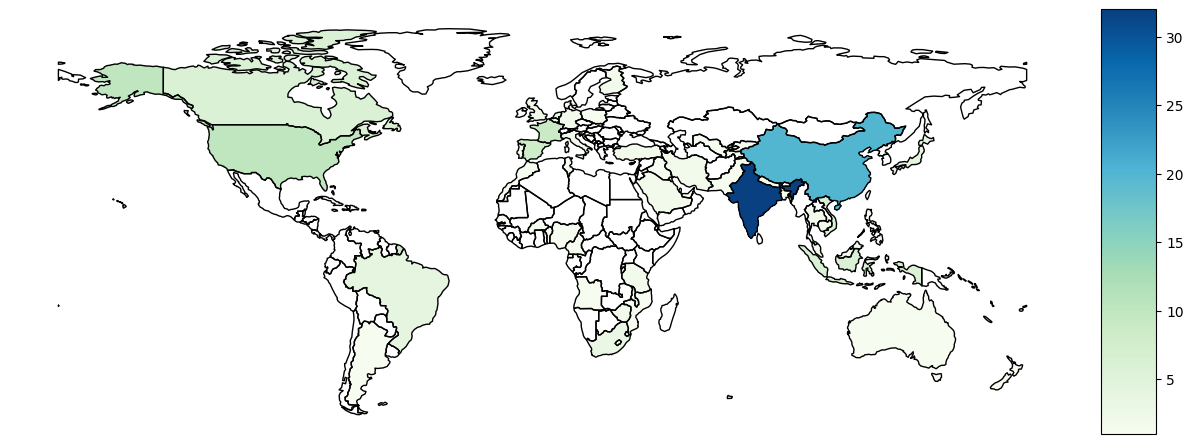

In [18]:
# plot results as choropleth map

# set map size
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 12.5)
# plt.style.use('default')

# configure legend panel size to be same as map size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plot country borders & number of study areas per country
world = countries[~countries["name"].isin(["Antarctica"])]
world.boundary.plot(ax=ax, color='black', linewidth=1)
pubs_country.plot(column='pubs_per_country', ax=ax, legend=True, cax=cax, cmap="GnBu")

ax.set_axis_off()

# save figure
fig.savefig(os.path.join('figures', 'study_areas.png'), dpi=600)

In [11]:
%%capture
# plotting study areas as interactive point map
# create country base map
country_geojson_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson'

result_map = folium.Map(tiles=None, location=[30, 0], zoom_start=2)
folium.GeoJson(
    country_geojson_url,
    style_function=lambda feature: {
        'fillColor': 'white',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }
).add_to(result_map)

# function for map popups
def to_html_string(row):
    html = str(row['filename']) + "<br>"
    html += "result string: " + str(row['geocode_str']) + "<br>"
    html += "result point: " + str(row['geocode_lat']) + ", " + str(row['geocode_lon']) + "<br>"
    return html

# adding geocoded results
for index, row in df_geocoded.iterrows():
    lat = row['geocode_lat']
    lon = row['geocode_lon']
    html_for_popup = folium.Html(to_html_string(row), script=True)
    html_popup = folium.Popup(html_for_popup, max_width=400)
    folium.CircleMarker([lat,lon], 
                    radius=5,
                    popup=html_popup,
                    color='#3186cc'
                   ).add_to(result_map)

In [19]:
# export map to html file
result_map.save(os.path.join('figures', 'study_area_map.html'))
# show map
result_map